In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from typing import Iterable
import pickle

In [135]:
file_path = "../data/dataset_disruption_characterization.pickle"
if os.path.exists(file_path):
    with open(file_path, "rb") as f:
        dataset = pickle.load(f)
else:
    print("File not found.")

data_raw_path = "../data/DISR_data"
def load_raw_signal(shot):
    return pd.read_parquet(os.path.join(data_raw_path, f"JET_DATAno{shot}.parquet"))

## Create dataset

In [136]:
shots = []
for i in range(len(dataset)):
    shots.append(dataset[i]['metadata']['shot'])

print("Shots in dataset:")
print(len(np.unique(shots)))

Shots in dataset:
137


In [142]:
df_data = pd.DataFrame()

# Loop through each entry in the dataset
for i, entry in enumerate(dataset):
    # Extract data and label from the current entry
    d = entry['x']
    label = entry['y']

    # Create a DataFrame for the current entry
    df = pd.DataFrame(d['data'], columns=d['columns'])   
    df['Frame'] = range(0, 20)
    df['Label'] = label
    df['Time'] = d['time']
    df["Distance"] = df["IPLA"] - df["IPref"]
    df['Shot'] = entry['metadata']['shot']

    # Append the current DataFrame to the main DataFrame
    df_data = pd.concat([df_data, df], ignore_index=True)


df_data = df_data.dropna()
#display every row
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
#display(df_data)

In [144]:
df_data.head(4)

,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,Frame,Label,Time,Distance,Shot
0,1989456.750,1999500.0,1740.929077,0.008850,1.191489,3.874169,0.30388,-0.519496,0,0,10.361,-10043.250,81206
1,1989606.250,1999500.0,1744.737427,0.008850,1.191489,3.874169,0.30388,-0.758418,1,0,10.362,-9893.750,81206
2,1988484.000,1999500.0,1756.823730,0.008698,1.191489,3.874169,0.30388,-1.037327,2,0,10.363,-11016.000,81206
3,1989329.625,1999500.0,1756.823730,0.008469,1.191489,3.874169,0.30388,-0.758418,3,0,10.364,-10170.375,81206


In [141]:
df_data_raw = df_data.copy()

### Minor event counting

This section counts the number of minor event that happenend before a certain window. This is a measure of instability.

In [146]:
#make a for loop per shot
shots = df_data['Shot'].unique()
#add a column to the dataframe called order
df_data['Order'] = 0
for shot in shots :
    #take frame 0
    df_shot = df_data[df_data['Shot'] == shot]
    df_shot = df_shot[df_shot['Frame'] == 0]
    #take the time of the frame 0
    time = df_shot['Time'].values

    for l in range (len(time)):
        #take the index in the data of the smallest time
        index = df_shot['Time'].idxmin()
        #set the order column of the index to 1
        df_data.loc[index, 'Order'] = l
        #set the order to the next 18 rows
        for i in range(1, 20):
            df_data.loc[index+i, 'Order'] = l
        #drop the value of the time array so the next smallest value will be taken
        df_shot = df_shot.drop(index)

def process_shot_group(group):
    minor_event_tracker = 0
    minor_events = []
    #sort by order column
    group = group.sort_values(by=['Order'])

    for i in group.index[::20]:  # Iterate over the index, stepping by 20
        minor_events.extend([minor_event_tracker] * 20)


        if group.at[i, 'Label'] == 1:  # Check the label at every 20th row
            minor_event_tracker += 1
        elif group.at[i, 'Label'] == 2:
            minor_event_tracker +=5

    group['Minor events that occurred yet'] = minor_events
    return group

# Apply the function to each 'Shot' group
grouped_df = df_data.groupby('Shot').apply(process_shot_group).reset_index(drop=True)
# Display the result
grouped_df = grouped_df.groupby(by=['Shot', 'Order'], group_keys=False).apply(lambda x: x.sort_values(by=['Frame'])).reset_index(drop=True)

grouped_df['Label'] = grouped_df['Label'].astype(float)
df_data = grouped_df


### Window creation
The following code takes all the data, separates it into windows of 15ms per each label. We end up with 3 dataframes of windows, one per each label.
This code is split for clarity but it can all be run in a row


#### Dictionnary creation

In [148]:
#get the distance from the each row
#create a dictionnary with a distance column
dict_windows = {'distances' :[],'distance_mean':[],'minor_events':[],'instability_x_current' :[],'ECEcore' :[],'ECEcore_mean':[],'ECEcore_dx1':[],'ECEcore_dx2':[], 'ZMAG':[],'ZMAG_mean' :[],'LI' :[], 'LI_mean' :[],'IPLA' :[], 'shot':[], 'label':[],'window' :[], 'IPLA_dx1' :[], 'IPLA_dx2' : [], 'IPLA_dx3' :[], 'IPLA_ddx' : [], 'fft_low': [],'IPLA_1' : [], 'IPLA_2' : [], 'IPLA_3' :[], 'IPLA_4' : [],'IPLA_mean':[],'time_window' : [], 'Vloop_1' : [],'Vloop_2' : [], 'Vloop_3' :[], 'Vloop_4' :[]}

df_data_group = df_data.groupby('Label')
#df_data_group_0 = df_data_group.get_group(0)

distances = []
IPLA = []
derivative_1 = []
derivative_2 = []
derivative_3 = []
double_derivatives = []
window_counter = 0
fft_results = []
fs = 1000  # Sampling frequency in Hz
dt = 1/fs  # Time step in seconds

for j in range(3):

    distances_j = []
    distances_mean_j = []

    IPLA_j = []
    IPLA_1_j = []
    IPLA_2_j = []
    IPLA_3_j = []
    IPLA_4_j = []
    IPLA_mean_j = []

    Vloop_1_j = []
    Vloop_2_j = []
    Vloop_3_j = []
    Vloop_4_j = []

    ECEcore_j = []
    ECEcore_mean_j = []
    ECEcore_dx1_j = []
    ECEcore_dx2_j = []

    ZMAG_j = []
    ZMAG_mean_j = []

    LI_j = []
    LI_mean_j = []

    minor_events_j = []
    instabilities_x_current_j = []

    fft_results_j = []

    derivative_1_j= []
    derivative_2_j = []
    derivative_3_j = []
    IPLA_ddxs_j = []

    shots_j = []

    window_j =[]
    time_window_j = []

    df_data_group_j = df_data_group.get_group(j)

    for i in range(0,df_data_group_j.shape[0],20):

        #take the first 20 rows
        df_data_sliced = df_data_group_j.iloc[i:i+20]
        df_data_sliced = df_data_sliced.iloc[5:20]

        df_data_distance = df_data_sliced['Distance']
        df_data_distance = df_data_distance.to_numpy().astype(np.float64)

        df_data_current = df_data_sliced['IPLA']
        df_data_current = df_data_current.to_numpy()

        #get the distance from the each row
        distances_j.append(df_data_distance)
        distances_mean_j.append(np.mean(df_data_distance))

        IPLA_j.append(df_data_current)
        # best current time points
        IPLA_1_j.append(df_data_current[14])
        IPLA_2_j.append(df_data_current[6])
        IPLA_3_j.append(df_data_current[7])
        IPLA_4_j.append(df_data_current[5])
        IPLA_mean_j.append(np.mean(df_data_current))


        df_mean = np.mean(df_data_distance)

        #take the fft of the current
        fft_res = np.fft.fft(df_data_current)
        fft_res = np.abs(np.array(fft_res))
        fft_results_j.append(fft_res[0])
        
        df_data_ECEcore = df_data_sliced['ECEcore'].to_numpy()
        ECEcore_j.append(df_data_ECEcore)
        ECEcore_mean_j.append(np.mean(df_data_ECEcore))


        df_data_ece_derivative = np.diff(df_data_ECEcore)[-2:]

        ECEcore_dx1_j.append(df_data_ece_derivative[0])
        ECEcore_dx2_j.append(df_data_ece_derivative[1])

        df_data_ZMAG = df_data_sliced['ZMAG'].to_numpy()
        ZMAG_j.append(df_data_ZMAG)
        ZMAG_mean_j.append(np.mean(df_data_ZMAG))

        minor_events_j.append(np.mean(df_data_sliced['Minor events that occurred yet'].to_numpy()))
        instabilities_x_current_j.append(np.mean(minor_events_j[-1]*df_data_current))

        df_data_LI = df_data_sliced['LI'].to_numpy()
        LI_j.append(df_data_LI)
        LI_mean_j.append(np.mean(df_data_LI))


        Vloop_1_j.append(df_data_sliced['Vloop'].to_numpy()[14])
        Vloop_2_j.append((df_data_sliced['Vloop'].to_numpy()[13]+df_data_sliced['Vloop'].to_numpy()[11]+df_data_sliced['Vloop'].to_numpy()[10])/3)
        Vloop_3_j.append((df_data_sliced['Vloop'].to_numpy()[5]+df_data_sliced['Vloop'].to_numpy()[6]+df_data_sliced['Vloop'].to_numpy()[7]+df_data_sliced['Vloop'].to_numpy()[8])/4)
        Vloop_4_j.append(df_data_sliced['Vloop'].to_numpy()[2])




        #take the derivative of the distance
        df_data_derivative = np.diff(df_data_current)[-3:]
        derivative_1_j.append(df_data_derivative[0])
        derivative_2_j.append(df_data_derivative[1])
        derivative_3_j.append(df_data_derivative[2])


        #take the double derivative of the distance
        df_data_IPLA_ddx = np.diff(df_data_derivative)[-1:]
        IPLA_ddxs_j.append(df_data_IPLA_ddx)

        #take the shot number
        df_data_shot = df_data_sliced['Shot']
        df_data_shot = df_data_shot.to_numpy()
        shots_j.append(df_data_shot[0])

        window_counter += 1
        window_j.append(window_counter)
        time_window_j.append(df_data_sliced['Time'].to_numpy()[0])


    distances_j = np.array(distances_j)
    distances.append(distances_j)

    fft_results_j = np.array(fft_results_j)
    fft_results.append(fft_results_j)

    IPLA_j = np.array(IPLA_j)
    IPLA.append(IPLA_j)

    derivative_1_j = np.array(derivative_1_j)
    derivative_1.append(derivative_1_j)

    derivative_2_j = np.array(derivative_2_j)
    derivative_2.append(derivative_2_j)

    derivative_3_j = np.array(derivative_3_j)
    derivative_3.append(derivative_3_j)


    #double_derivatives_j = np.array(double_derivatives_j)
    double_derivatives.append(IPLA_ddxs_j)

    dict_windows['distances'].append(distances_j)
    dict_windows['distance_mean'].append(distances_mean_j)

    dict_windows['fft_low'].append(fft_results_j)

    dict_windows['IPLA'].append(IPLA_j)
    dict_windows['IPLA_1'].append(IPLA_1_j)
    dict_windows['IPLA_2'].append(IPLA_2_j)
    dict_windows['IPLA_3'].append(IPLA_3_j)
    dict_windows['IPLA_4'].append(IPLA_4_j)
    dict_windows['IPLA_mean'].append(IPLA_mean_j)

    dict_windows['Vloop_1'].append(Vloop_1_j)
    dict_windows['Vloop_2'].append(Vloop_2_j)
    dict_windows['Vloop_3'].append(Vloop_3_j)
    dict_windows['Vloop_4'].append(Vloop_4_j)

    dict_windows['ECEcore'].append(ECEcore_j)
    dict_windows['ECEcore_mean'].append(ECEcore_mean_j)
    dict_windows['ECEcore_dx1'].append(ECEcore_dx1_j)
    dict_windows['ECEcore_dx2'].append(ECEcore_dx2_j)
    
    dict_windows['ZMAG'].append(ZMAG_j)
    dict_windows['ZMAG_mean'].append(ZMAG_mean_j)

    dict_windows['LI'].append(LI_j)
    dict_windows['LI_mean'].append(LI_mean_j)
    
    dict_windows['minor_events'].append(minor_events_j)
    dict_windows['instability_x_current'].append(instabilities_x_current_j)
    

    dict_windows['shot'].append(shots_j)

    dict_windows['label'].append(j)

    dict_windows['window'].append(window_j)
    dict_windows['time_window'].append(time_window_j)

    dict_windows['IPLA_dx1'].append(derivative_1_j)
    dict_windows['IPLA_dx2'].append(derivative_2_j)
    dict_windows['IPLA_dx3'].append(derivative_3_j)

    dict_windows['IPLA_ddx'].append(IPLA_ddxs_j)

#Create the 3 dictionnaries per label
    
dict_windows_0 = {'distances' :[],'distance_mean':[],'minor_events':[],'instability_x_current' :[],'ECEcore' :[],'ECEcore_mean':[],'ECEcore_dx1':[],'ECEcore_dx2':[], 'ZMAG':[],'ZMAG_mean' :[],'LI' :[], 'LI_mean':[],'IPLA' :[],'fft_low' :[],'shot':[], 'label':[],'window' :[], 'IPLA_dx1' :[], 'IPLA_dx2' : [], 'IPLA_dx3' :[], 'IPLA_ddx' : [], 'IPLA_1' : [], 'IPLA_2' : [], 'IPLA_3' :[], 'IPLA_4' : [],'IPLA_mean':[], 'time_window' : [],'Vloop_1' : [],'Vloop_2' : [], 'Vloop_3' :[], 'Vloop_4' :[]}
dict_windows_1 = {'distances' :[],'distance_mean':[],'minor_events':[],'instability_x_current' :[],'ECEcore' :[],'ECEcore_mean':[],'ECEcore_dx1':[],'ECEcore_dx2':[], 'ZMAG':[],'ZMAG_mean' :[],'LI' :[],'LI_mean':[],'IPLA' :[],'fft_low' :[], 'shot':[], 'label':[],'window' :[], 'IPLA_dx1' :[], 'IPLA_dx2' : [], 'IPLA_dx3' :[], 'IPLA_ddx' : [], 'IPLA_1' : [], 'IPLA_2' : [], 'IPLA_3' :[], 'IPLA_4' : [], 'IPLA_mean':[],'time_window' : [],'Vloop_1' : [],'Vloop_2' : [], 'Vloop_3' :[], 'Vloop_4' :[]}
dict_windows_2 = {'distances' :[],'distance_mean':[],'minor_events':[],'instability_x_current' :[],'ECEcore' :[],'ECEcore_mean':[],'ECEcore_dx1':[],'ECEcore_dx2':[], 'ZMAG':[],'ZMAG_mean' :[],'LI' :[],'LI_mean':[], 'IPLA' :[],'fft_low' :[],'shot':[], 'label':[],'window' :[], 'IPLA_dx1' :[], 'IPLA_dx2' : [], 'IPLA_dx3' :[], 'IPLA_ddx' : [], 'IPLA_1' : [], 'IPLA_2' : [], 'IPLA_3' :[], 'IPLA_4' : [], 'IPLA_mean':[],'time_window' : [],'Vloop_1' : [],'Vloop_2' : [], 'Vloop_3' :[], 'Vloop_4' :[]}

for i in dict_windows.keys():
    dict_windows_0[i] = dict_windows[i][0]
    dict_windows_1[i] = dict_windows[i][1]
    dict_windows_2[i] = dict_windows[i][2]

#### Format the arrays for conversion to dataframe


In [149]:
#extend the label column to match the shape of the other columns
n_0 = dict_windows_0['distances'].shape[0]
dict_windows_0['label'] = np.full(n_0, dict_windows_0['label'])

n_1 = dict_windows_1['distances'].shape[0]
dict_windows_1['label'] = np.full(n_1, dict_windows_1['label'])

n_2 = dict_windows_2['distances'].shape[0]
dict_windows_2['label'] = np.full(n_2, dict_windows_2['label'])

#change distance column and IPLA to a list of arrays so it can be converted to a dataframe
distances = []
IPLA = []
ZMAG =[]
ECEcore = []
LI = []
for i in range(dict_windows_0['distances'].shape[0]):
    distances.append(dict_windows_0['distances'][i])
    IPLA.append(dict_windows_0['IPLA'][i])
    ZMAG.append(dict_windows_0['ZMAG'][i])
    ECEcore.append(dict_windows_0['ECEcore'][i])
    LI.append(dict_windows_0['LI'][i])


dict_windows_0['distances'] = distances
dict_windows_0['IPLA'] = IPLA
dict_windows_0['ZMAG'] = ZMAG
dict_windows_0['ECEcore'] = ECEcore
dict_windows_0['LI'] = LI

distances = []
IPLA = []
ZMAG =[]
ECEcore = []
LI = []
for i in range(dict_windows_1['distances'].shape[0]):
    distances.append(dict_windows_1['distances'][i])
    IPLA.append(dict_windows_1['IPLA'][i])
    ZMAG.append(dict_windows_1['ZMAG'][i])
    ECEcore.append(dict_windows_1['ECEcore'][i])
    LI.append(dict_windows_1['LI'][i])

dict_windows_1['distances'] = distances
dict_windows_1['IPLA'] = IPLA
dict_windows_1['ZMAG'] = ZMAG
dict_windows_1['ECEcore'] = ECEcore
dict_windows_1['LI'] = LI

distances = []
IPLA = []
ZMAG =[]
ECEcore = []
LI = []
for i in range(dict_windows_2['distances'].shape[0]):
    distances.append(dict_windows_2['distances'][i])
    IPLA.append(dict_windows_2['IPLA'][i])
    ZMAG.append(dict_windows_2['ZMAG'][i])
    ECEcore.append(dict_windows_2['ECEcore'][i])
    LI.append(dict_windows_2['LI'][i])

dict_windows_2['distances'] = distances
dict_windows_2['IPLA'] = IPLA
dict_windows_2['ZMAG'] = ZMAG
dict_windows_2['ECEcore'] = ECEcore
dict_windows_2['LI'] = LI

#change double derivative column to a list
double_derivative = []
for i in range(np.shape(dict_windows_0['IPLA_ddx'])[0]):
    double_derivative.append(dict_windows_0['IPLA_ddx'][i][0])
    
dict_windows_0['IPLA_ddx'] = double_derivative

double_derivative = []
for i in range(np.shape(dict_windows_1['IPLA_ddx'])[0]):
    double_derivative.append(dict_windows_1['IPLA_ddx'][i][0])

dict_windows_1['IPLA_ddx'] = double_derivative

double_derivative = []
for i in range(np.shape(dict_windows_2['IPLA_ddx'])[0]):
    double_derivative.append(dict_windows_2['IPLA_ddx'][i][0])

dict_windows_2['IPLA_ddx'] = double_derivative


#### Change to dataframe

In [150]:
#dict_windows_0 to dataframe
df_windows_0 = pd.DataFrame.from_dict(dict_windows_0)
df_windows_0.head(21)
#dict_windows_1 to dataframe
df_windows_1 = pd.DataFrame.from_dict(dict_windows_1)
df_windows_1.head(21)
#dict_windows_0 to dataframe
df_windows_2 = pd.DataFrame.from_dict(dict_windows_2)
df_windows_2.head(21)

#concatenate the 3
df_windows = pd.concat([df_windows_0, df_windows_1, df_windows_2], ignore_index=True)

#### Save to CSV

In [151]:
#save the dataframes to csv
df_windows_0.to_csv('../data/df_windows_0.csv', index=False)
df_windows_1.to_csv('../data/df_windows_1.csv', index=False)
df_windows_2.to_csv('../data/df_windows_2.csv', index=False)
df_windows.to_csv('../data/df_windows.csv', index=False)

# Data visualization
This section shows how the features vary according to the three labels. This was helpful for the feature engineering.

## FFT

### FFT Calculation

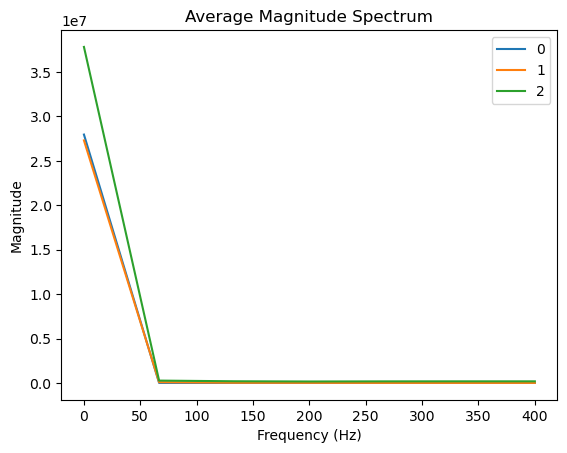

In [40]:
# Initialize an empty array to store the FFT results
fft_results_0 = []
fft_results_1 = []
fft_results_2 = []

fs = 1000  # Sampling frequency in Hz
dt = 1/fs  # Time step in seconds

# Iterate over each row in df_windows_0['IPLA']
for time_series in df_windows_0['IPLA']:
    # Compute the FFT
    fft_result = np.fft.fft(time_series)
    # Append the FFT result to the array
    fft_results_0.append(fft_result)

# Iterate over each row in df_windows_0['IPLA']
for time_series in df_windows_1['IPLA']:
    # Compute the FFT
    fft_result = np.fft.fft(time_series)
    # Append the FFT result to the array
    fft_results_1.append(fft_result)

# Iterate over each row in df_windows_0['IPLA']
for time_series in df_windows_2['IPLA']:
    # Compute the FFT
    fft_result = np.fft.fft(time_series)
    # Append the FFT result to the array
    fft_results_2.append(fft_result)

# Convert the array to a numpy array
fft_results_0 = np.array(fft_results_0)
fft_results_1 = np.array(fft_results_1)
fft_results_2 = np.array(fft_results_2)


# Compute the average FFT over all the rows
average_fft_0 = np.mean(fft_results_0, axis=0)
average_fft_1 = np.mean(fft_results_1, axis=0)
average_fft_2 = np.mean(fft_results_2, axis=0)

# Compute the magnitude spectrum of the average FFT
magnitude_spectrum_0 = np.abs(average_fft_0)
magnitude_spectrum_1 = np.abs(average_fft_1)
magnitude_spectrum_2 = np.abs(average_fft_2)

# Compute the frequency bins
freq_bins = np.fft.fftfreq(len(time_series), d=dt)


# Plot the average magnitude spectrum
plt.plot(freq_bins[:len(time_series)//2], magnitude_spectrum_0[:len(time_series)//2], label='0')
plt.plot(freq_bins[:len(time_series)//2], magnitude_spectrum_1[:len(time_series)//2], label='1')
plt.plot(freq_bins[:len(time_series)//2], magnitude_spectrum_2[:len(time_series)//2], label='2')

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Average Magnitude Spectrum')
plt.legend()


We see that there is a significant difference in the low frequencies which might help the model

### Low Frequencies

Plot of the low frequencies obtained from Fast Fourier Transform.

C:\Users\ricca\AppData\Local\Temp\ipykernel_13232\3288563967.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_windows_0_group_mean = df_windows_0_group.mean()
C:\Users\ricca\AppData\Local\Temp\ipykernel_13232\3288563967.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_windows_1_group_mean = df_windows_1_group.mean()
C:\Users\ricca\AppData\Local\Temp\ipykernel_13232\3288563967.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be vali

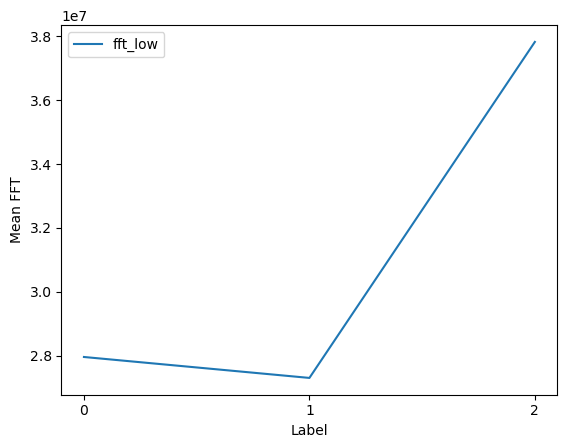

In [41]:
# plot the fft per group of label,
# take the mean of the fft per group of label
df_windows_0_group = df_windows_0.groupby('label')
df_windows_1_group = df_windows_1.groupby('label')
df_windows_2_group = df_windows_2.groupby('label')

df_windows_0_group_mean = df_windows_0_group.mean()
df_windows_1_group_mean = df_windows_1_group.mean()
df_windows_2_group_mean = df_windows_2_group.mean()

y = [df_windows_0_group_mean['fft_low'].to_numpy()[0], df_windows_1_group_mean['fft_low'].to_numpy()[0], df_windows_2_group_mean['fft_low'].to_numpy()[0]]

# plot the data
plt.plot(['0', '1', '2'], y, label='fft_low')
plt.xlabel('Label')
plt.ylabel('Mean FFT')
plt.legend()
plt.show()


We see a significant difference from Frequencies depending on the event type

## IPLA

In [22]:
ipa1  = np.mean(df_windows_0['IPLA'],axis=0)
ipa2 = np.mean(df_windows_1['IPLA'],axis=0)
ipa3 = np.mean(df_windows_2['IPLA'],axis=0)

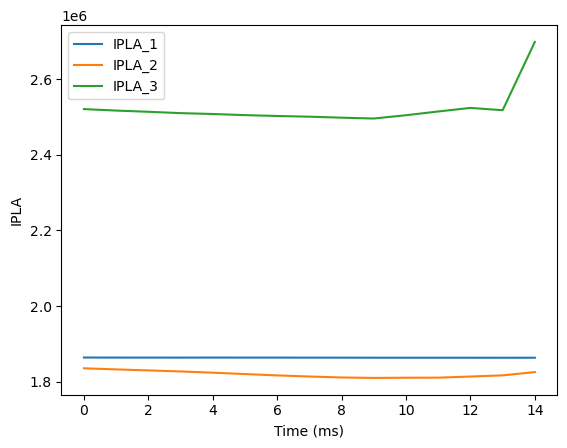

In [24]:
plt.plot(ipa1, label='IPLA_1')
plt.plot(ipa2, label='IPLA_2')
plt.plot(ipa3, label='IPLA_3')
plt.xlabel('Time (ms)')
plt.ylabel('IPLA')
plt.legend()

## ECE

### ECE mean

In [25]:

ece_0  = np.mean(df_windows_0['ECEcore'],axis=0)
ece_1 = np.mean(df_windows_1['ECEcore'],axis=0)
ece_2 = np.mean(df_windows_2['ECEcore'],axis=0)

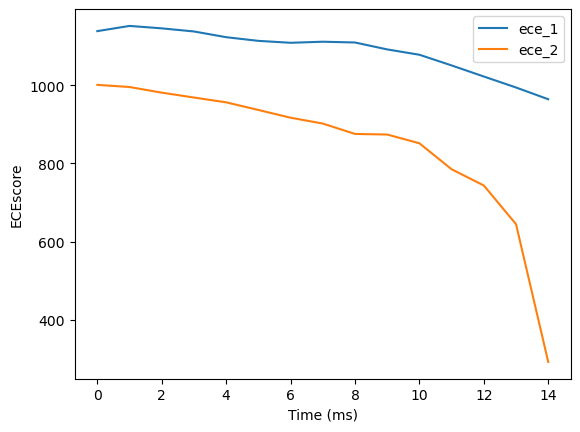

In [26]:
#plot ece_0
#plt.plot(ece_0, label='ece_0') #Plotting the ECEscore for label 0 collapses the scale of the ECE 1 and 2, uncomment the line to see
plt.plot(ece_1, label='ece_1')
plt.plot(ece_2, label='ece_2')
plt.xlabel('Time (ms)')
plt.ylabel('ECEscore')
plt.legend()


### ECE first derivative at the frame 13-14(dx1) and 14-15(dx2)

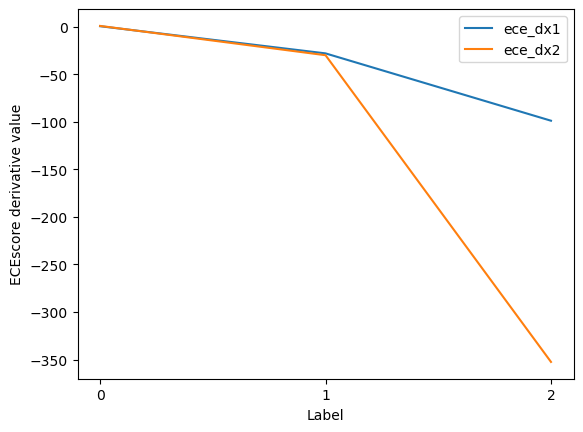

In [30]:
ece_0  = np.mean(df_windows_0['ECEcore_dx1'],axis=0)
ece_1 = np.mean(df_windows_1['ECEcore_dx1'],axis=0)
ece_2 = np.mean(df_windows_2['ECEcore_dx1'],axis=0)

ece_0_dx2 =  np.mean(df_windows_0['ECEcore_dx2'],axis=0)
ece_1_dx2 = np.mean(df_windows_1['ECEcore_dx2'],axis=0)
ece_2_dx2 = np.mean(df_windows_2['ECEcore_dx2'],axis=0)

plt.plot(['0','1','2'],[ece_0, ece_1, ece_2], label='ece_dx1')
plt.plot(['0','1','2'],[ece_0_dx2, ece_1_dx2, ece_2_dx2], label='ece_dx2')
plt.xlabel('Label')
plt.ylabel('ECEscore derivative value')
plt.legend()


## ZMAG

In [31]:
zmag1  = np.mean(df_windows_0['ZMAG'],axis=0)
zmag2 = np.mean(df_windows_1['ZMAG'],axis=0)
zmag3 = np.mean(df_windows_2['ZMAG'],axis=0)


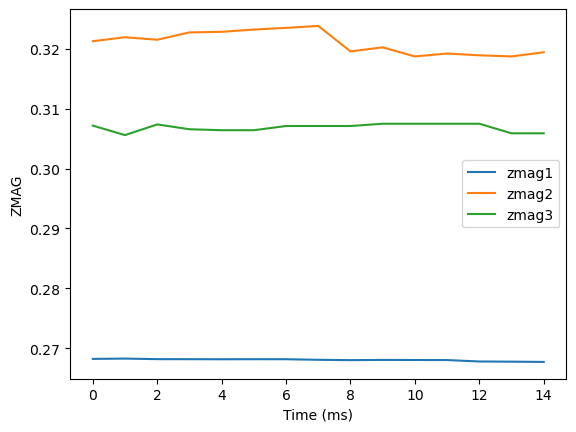

In [33]:
plt.plot(zmag1, label='zmag1')
plt.plot(zmag2, label='zmag2')
plt.plot(zmag3, label='zmag3')
plt.xlabel('Time (ms)')
plt.ylabel('ZMAG')
plt.legend()


## LI

In [34]:
li1  = np.mean(df_windows_0['LI'],axis=0)
li2 = np.mean(df_windows_1['LI'],axis=0)
li3 = np.mean(df_windows_2['LI'],axis=0)


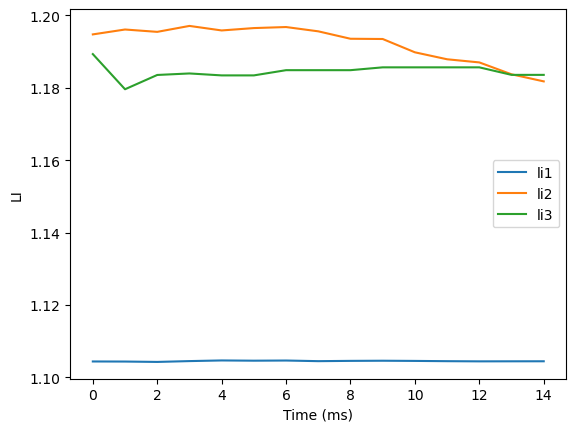

In [36]:
plt.plot(li1, label='li1')
plt.plot(li2, label='li2')
plt.plot(li3, label='li3')
plt.xlabel('Time (ms)')
plt.ylabel('LI')
plt.legend()

## Distance

In [37]:
di1  = np.mean(df_windows_0['distances'],axis=0)
di2 = np.mean(df_windows_1['distances'],axis=0)
di3 = np.mean(df_windows_2['distances'],axis=0)

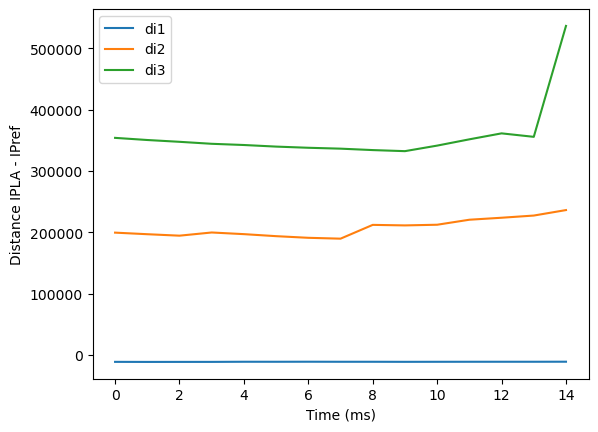

In [39]:
plt.plot(di1, label='di1')
plt.plot(di2, label='di2')
plt.plot(di3, label='di3')
plt.xlabel('Time (ms)')
plt.ylabel('Distance IPLA - IPref')
plt.legend()

# Joint part

In [123]:
import process_data
from importlib import reload
reload(process_data)

<module 'process_data' from 'c:\\Users\\ricca\\OneDrive\\Documenti\\GitHub\\ml_tokamak\\code\\process_data.py'>

## Data preprocessing

### Take data from NN

In [124]:
#load the data pipeline.csv 
data_pipeline = pd.read_csv('../data/pipeline.csv')

In [125]:
data_pipeline.head(4)

,time,IPLA,IPref,ECEcore,SSXcore,LI,Q95,ZMAG,Vloop,IPE,Instability,Window
0,0.022,-53160.492,0.022461,1141.5006,0.002289,0.661752,10.408838,0.020125,-17.961126,-53160.516,0,1
1,0.023,-56066.082,0.022461,1141.5006,0.001373,0.661752,10.408838,0.020125,-17.642231,-56066.105,0,1
2,0.024,-59827.996,0.022461,1141.5006,0.000916,0.661752,10.408838,0.020125,-18.239368,-59828.020,0,1
3,0.025,-63139.010,0.022461,1141.5006,0.001679,0.661752,10.408838,0.020125,-18.200048,-63139.035,0,1


### Convert it to a window format

In [126]:
#group by window
data_pipeline_window = data_pipeline.groupby('Window')
#extract a window from the groupby object
data_pipeline_window.get_group(1)
#get all the windows    
windows_pipeline = []
for i in range(1, data_pipeline_window.ngroups):
    #take only the 15 last rows of the window data_pipeline_window.get_group(i)
    tmp = process_data.NN_data_to_window(data_pipeline_window.get_group(i).iloc[-15:])
    windows_pipeline.append(tmp)


In [127]:
windows_pipeline[0]

,distance_mean,minor_events,ECEcore_mean,ECEcore_dx1,ECEcore_dx2,ZMAG_mean,LI_mean,IPLA_dx1,IPLA_dx2,IPLA_dx3,IPLA_ddx,fft_low,IPLA_1,IPLA_2,IPLA_3,IPLA_4,IPLA_mean,time_window,Vloop_1,Vloop_2,Vloop_3,Vloop_4
0,-98412.823933,0,1141.5006,0.0,0.0,0.020125,0.661752,-2998.735,-4382.8,-4643.67,-260.87,1476192.015,-126462.4,-94350.37,-98626.21,-89761.03,-98412.801,0.027,-17.400976,-17.747529,-17.45246,-17.642231


## SVM prediction

In [129]:
#convert windows_pipeline to a pd.DataFrame
X_pipeline = pd.DataFrame()
for i in range(len(windows_pipeline)):
    X_pipeline = X_pipeline.append(windows_pipeline[i])
X_pipeline.drop('time_window', axis=1, inplace=True)
X_pipeline.drop('minor_events', axis=1, inplace=True)

C:\Users\ricca\AppData\Local\Temp\ipykernel_12556\3374233050.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_pipeline = X_pipeline.append(windows_pipeline[i])
C:\Users\ricca\AppData\Local\Temp\ipykernel_12556\3374233050.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_pipeline = X_pipeline.append(windows_pipeline[i])
C:\Users\ricca\AppData\Local\Temp\ipykernel_12556\3374233050.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_pipeline = X_pipeline.append(windows_pipeline[i])
C:\Users\ricca\AppData\Local\Temp\ipykernel_12556\3374233050.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_pipeline = X_pipeline.append(windo

In [130]:
#adjust column names
X_pipeline = X_pipeline[X_test.columns]

In [132]:
y_pred = best_svm_model.predict(X_pipeline)

## Load shot

In [92]:
#take data where the shot is 96885
data_96885 = data[data['shot'] == 96885]
#find the shot

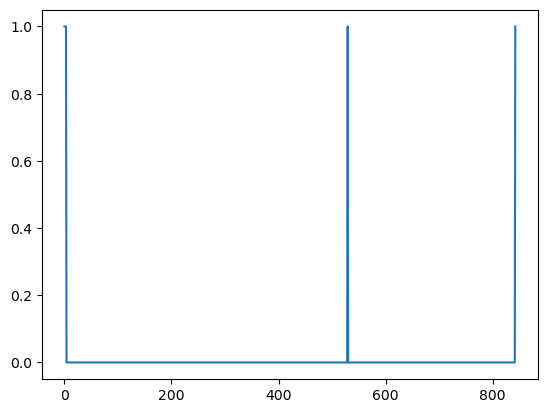

In [133]:
plt.plot(y_pred)

In [99]:
(len(data_96885[data_96885['label'] == 1]))

1